In [176]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from biomart import BiomartServer
import io

In [177]:
#os.getcwd()

# Linux workstation
#data_path = '/home/db600/phd/data/'

# Laptop
data_path = 'C:\\Users\\dan\\Documents\\phd\\data\\'

os.listdir(data_path)

['biomart',
 'depmap',
 'missing_gene_names.csv',
 'pathway_commons',
 'reactome',
 'reactome_rows_to_drop.csv',
 'string']

In [178]:
os.listdir(data_path + '/pathway_commons/')

['PathwayCommons12.reactome.hgnc.gmt',
 'PathwayCommons12.reactome.hgnc.gmt.gz',
 'PathwayCommons12.reactome.hgnc.sif',
 'PathwayCommons12.reactome.hgnc.sif.gz',
 'PathwayCommons12.reactome.hgnc.txt',
 'PathwayCommons12.reactome.hgnc.txt.gz',
 'PathwayCommons12.reactome.uniprot.gmt',
 'PathwayCommons12.reactome.uniprot.gmt.gz']

In [179]:
reactome_sif = pd.read_csv(data_path + "pathway_commons/PathwayCommons12.reactome.hgnc.sif", sep="\t")
reactome_sif.head()
reactome_sif.columns = ['PARTICIPANT_A', 'INTERACTION_TYPE', 'PARTICIPANT_B']
reactome_sif.columns

Index(['PARTICIPANT_A', 'INTERACTION_TYPE', 'PARTICIPANT_B'], dtype='object')

In [180]:
print(reactome_sif['INTERACTION_TYPE'].unique())

['in-complex-with' 'controls-state-change-of' 'controls-production-of'
 'controls-transport-of' 'controls-transport-of-chemical'
 'catalysis-precedes' 'controls-phosphorylation-of'
 'controls-expression-of' 'chemical-affects' 'used-to-produce'
 'consumption-controlled-by' 'reacts-with']


In [181]:
reactome_sif.head()

,PARTICIPANT_A,INTERACTION_TYPE,PARTICIPANT_B
0,A1CF,in-complex-with,APOBEC2
1,A1CF,in-complex-with,APOBEC3A
2,A1CF,in-complex-with,APOBEC3B
3,A1CF,in-complex-with,APOBEC3C
4,A1CF,in-complex-with,APOBEC3H


In [182]:
# Get row count for number of edges in the dataset
print(f'Edges: {len(reactome_sif)} (with duplicates)')

Edges: 353635 (with duplicates)


In [183]:
# The same pairs are included multiple times with different interaction labels. Filter out these duplicates
reactome_no_duplicates = reactome_sif.drop_duplicates(subset=['PARTICIPANT_A','PARTICIPANT_B'])

# How many edges remaning?
print(f'Edges: {len(reactome_no_duplicates)} (no duplicates)')

Edges: 329941 (no duplicates)


In [184]:
reactome_no_duplicates.head()

,PARTICIPANT_A,INTERACTION_TYPE,PARTICIPANT_B
0,A1CF,in-complex-with,APOBEC2
1,A1CF,in-complex-with,APOBEC3A
2,A1CF,in-complex-with,APOBEC3B
3,A1CF,in-complex-with,APOBEC3C
4,A1CF,in-complex-with,APOBEC3H


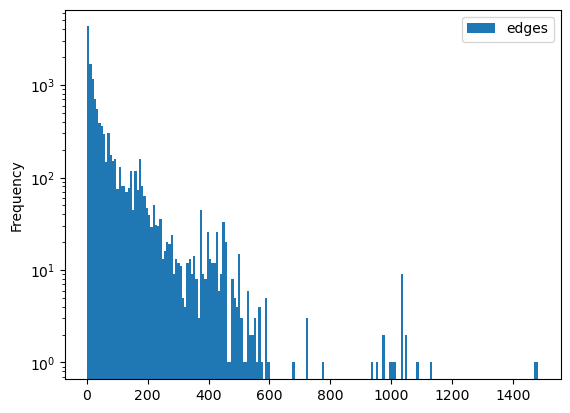

In [185]:
# Get number of nodes and edges and plot histogram of edges showing number of nodes with X edges 
total_gene_a = reactome_no_duplicates['PARTICIPANT_A'].tolist()
total_gene_b = reactome_no_duplicates['PARTICIPANT_B'].tolist()
total_genes = total_gene_a + total_gene_b

total_genes_df = pd.DataFrame(total_genes, columns=['gene'])

total_genes_df['edges'] = total_genes_df['gene'].map(total_genes_df['gene'].value_counts())

#total_genes_df.head()

unique_genes_df = total_genes_df.drop_duplicates('gene') 
unique_genes_df.sort_values(by='edges', ascending=False)

fig = unique_genes_df.plot(kind='hist', bins=200)

plt.yscale('log')
plt.show()

In [186]:
# See how many nodes there are
unique_gene_a = reactome_no_duplicates['PARTICIPANT_A'].unique().tolist()
unique_gene_b = reactome_no_duplicates['PARTICIPANT_B'].unique().tolist()
unique_gene_all = set(unique_gene_a + unique_gene_b)

print(f' Unique gene a: {len(unique_gene_a)}')
print(f' Unique gene b: {len(unique_gene_b)}')
print(f' Total unique nodes: {len(unique_gene_all)}')

#df = pd.DataFrame.from_dict(count, orient='index')
#df.plot(kind='bar')

 Unique gene a: 10055
 Unique gene b: 10907
 Total unique nodes: 12323


In [187]:
#Connect to a Biomart Server
server = BiomartServer("http://useast.ensembl.org/biomart")

# set verbose to True to get some messages
server.verbose = True

# use the 'hsapiens_gene_ensembl' dataset
hsapiens_gene_ensembl = server.datasets['hsapiens_gene_ensembl']

# show all available filters and attributes of the 'hsapiens_gene_ensembl' dataset
#hsapiens_gene_ensembl.show_filters()  # uses print
#hsapiens_gene_ensembl.show_attributes()  # uses print

# run a search with custom filters and attributes and a header
response = hsapiens_gene_ensembl.search({
  #'filters': {
  #    'ensembl_gene_id': unique_gene_all,
  #},
  'attributes': [
      'ensembl_gene_id', 'hgnc_symbol', 'external_gene_name', 'chromosome_name', 'ensembl_transcript_id', 'ensembl_peptide_id', 'uniprotsptrembl', 'uniprotswissprot'
  ]
}, header = 1)

# This code will write the response to screen line by line
# #response format is TSV
# for line in response.iter_lines():
#   line = line.decode('utf-8')
#   #print(line.split("\t"))

# Convert response to pandas dataframe
if response.ok:
    # Convert the response content to a file-like object
    content = io.StringIO(response.content.decode('utf-8'))

    # Read the content into a DataFrame
    biomart = pd.read_csv(content, sep='\t')
else:
    print("Error with the response")

[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching datasets
[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching databases
[BiomartDatabase:'Ensembl Genes 110'] Fetching datasets
[BiomartDatabase:'Mouse strains 110'] Fetching datasets
[BiomartDatabase:'Sequence'] Fetching datasets
[BiomartDatabase:'Ontology'] Fetching datasets
[BiomartDatabase:'Genomic features 110'] Fetching datasets
[BiomartDatabase:'Ensembl Variation 110'] Fetching datasets
[BiomartDatabase:'Ensembl Regulation 110'] Fetching datasets
[BiomartDataset:'hsapiens_gene_ensembl'] Searching using following params:
{'attributes': ['ensembl_gene_id',
                'hgnc_symbol',
                'external_gene_name',
                'chromosome_name',
                'ensembl_transcript_id',
                'ensembl_peptide_id',
                'uniprotsptrembl',
                'uniprotswissprot']}
[BiomartDataset:'hsapiens_gene_ensembl'] Fetching attributes
[BiomartDataset] search

In [188]:
# Alternative to using biomart package - use downloaded copy instead
#biomart = pd.read_csv(data_path + "biomart/ensg_enst_ensp_hgnc_name.txt")

In [189]:
biomart.head()

,Gene stable ID,HGNC symbol,Gene name,Chromosome/scaffold name,Transcript stable ID,Protein stable ID,UniProtKB/TrEMBL ID,UniProtKB/Swiss-Prot ID
0,ENSG00000198888,MT-ND1,MT-ND1,MT,ENST00000361390,ENSP00000354687,U5Z754,P03886
1,ENSG00000198763,MT-ND2,MT-ND2,MT,ENST00000361453,ENSP00000355046,Q7GXY9,P03891
2,ENSG00000198804,MT-CO1,MT-CO1,MT,ENST00000361624,ENSP00000354499,U5YWV7,P00395
3,ENSG00000198712,MT-CO2,MT-CO2,MT,ENST00000361739,ENSP00000354876,U5Z487,P00403
4,ENSG00000228253,MT-ATP8,MT-ATP8,MT,ENST00000361851,ENSP00000355265,U5YV54,P03928


In [190]:
print(f'Rows in conversion dataframe: {len(biomart)}')

Rows in conversion dataframe: 123120


In [191]:
# Biomart data will include multiple ensembl gene ids for each HGNC symbol due to patches and alternate sequences. 
# We only want one ENSG per HGNC symbol so we will use the primary assembly. To do this select only chromosomes/scaffolds 1-23 and X/Y
scaffolds = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']
biomart_primary = biomart[biomart['Chromosome/scaffold name'].isin(scaffolds)]

print(f'Rows in conversion dataframe: {len(biomart_primary)}')

Rows in conversion dataframe: 111338


In [192]:
# See how many duplicates there are (HGNC symbol/Gene stable ID combination)
print(len(biomart_primary[biomart_primary.duplicated(subset=['HGNC symbol', 'Gene stable ID'], keep=False)]))

# See how many rows are missing HGNC symbol
print(len(biomart_primary[biomart_primary['HGNC symbol'].isnull()]))

106807
1018


In [193]:
# Drop duplicate biomart rows and anything without an HGNC
biomart_no_null = biomart_primary.drop_duplicates(subset=['HGNC symbol', 'Gene stable ID'], keep='first')
print(len(biomart_no_null))

biomart_no_null = biomart_no_null.dropna(subset=['HGNC symbol'])
print(len(biomart_no_null))

20445
19825


In [194]:
# Code to map Gene stable IDs to PARTICIPANT_A and PARTICIPANT_B

# Create a mapping dictionary from the biomart dataframe
# Here we map 'HGNC symbol' to 'Gene stable ID'
hgnc_to_gene_id = biomart_no_null.set_index('HGNC symbol')['Gene stable ID'].to_dict()

# Use this dictionary to map the PARTICIPANT_A and PARTICIPANT_B values in the reactome dataframe to their corresponding Gene stable ID
reactome_no_duplicates['PARTICIPANT_A_ENSG'] = reactome_no_duplicates['PARTICIPANT_A'].map(hgnc_to_gene_id)
reactome_no_duplicates['PARTICIPANT_B_ENSG'] = reactome_no_duplicates['PARTICIPANT_B'].map(hgnc_to_gene_id)

# Show the modified dataframe
reactome_no_duplicates.head()

C:\Users\dan\AppData\Local\Temp\ipykernel_14824\4121304206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reactome_no_duplicates['PARTICIPANT_A_ENSG'] = reactome_no_duplicates['PARTICIPANT_A'].map(hgnc_to_gene_id)
C:\Users\dan\AppData\Local\Temp\ipykernel_14824\4121304206.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reactome_no_duplicates['PARTICIPANT_B_ENSG'] = reactome_no_duplicates['PARTICIPANT_B'].map(hgnc_to_gene_id)


,PARTICIPANT_A,INTERACTION_TYPE,PARTICIPANT_B,PARTICIPANT_A_ENSG,PARTICIPANT_B_ENSG
0,A1CF,in-complex-with,APOBEC2,ENSG00000148584,ENSG00000124701
1,A1CF,in-complex-with,APOBEC3A,ENSG00000148584,ENSG00000128383
2,A1CF,in-complex-with,APOBEC3B,ENSG00000148584,ENSG00000179750
3,A1CF,in-complex-with,APOBEC3C,ENSG00000148584,ENSG00000244509
4,A1CF,in-complex-with,APOBEC3H,ENSG00000148584,ENSG00000100298


In [195]:
unique_nodes = set(reactome_no_duplicates['PARTICIPANT_A_ENSG'].tolist() +  reactome_no_duplicates['PARTICIPANT_B_ENSG'].tolist())
print(f'Total unique nodes: {len(unique_nodes)}')
print(f'Total edges: {len(reactome_no_duplicates)}')

Total unique nodes: 10141
Total edges: 329941
